In [18]:
from mangaki.algo.svd import MangakiSVD
from mangaki.algo.als import MangakiALS
from mangaki.algo.pca import MangakiPCA
from mangaki.algo.knn import MangakiKNN
import numpy as np
from mangaki.utils.values import rating_values
from mangaki.algo.dataset import Dataset
from mangaki.algo.fit_algo import fit_algo, get_algo_backup, get_dataset_backup

dataset = Dataset()
dataset.load_csv('ratings.csv', convert=lambda choice: rating_values[choice], title_filename='works.csv')
titles = dataset.titles

In [45]:
svd = MangakiPCA()
svd.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
svd.fit(dataset.anonymized.X, dataset.anonymized.y)

print(svd.predict(dataset.anonymized.X)[:6])
print(dataset.anonymized.y[:6])

[ 0.30680529  0.99532148  0.4222483   0.84924746  0.3171571   1.46347117]
[ 0.5  4.   0.1  2.  -0.5  2. ]


In [46]:
popular = list(range(100))

In [47]:
svd.VT.T.shape

(10039, 10)

In [48]:
from collections import Counter

popular = Counter([work_id for _, work_id in dataset.anonymized.X])
popular_ids = [work_id for work_id, _ in popular.most_common(100)]

In [49]:
for work_id in popular_ids[:10]:
    print(titles[work_id])

Death Note
L'Attaque des Titans
Fullmetal Alchemist: Brotherhood
Princesse Mononoké
Le Voyage de Chihiro
Naruto
Sword Art Online
Fullmetal Alchemist
Naruto: Shippuuden
Bleach


In [50]:
dataset.encode_work = dict(zip(range(dataset.anonymized.nb_works), range(dataset.anonymized.nb_works)))

<IPython.core.display.Javascript object>


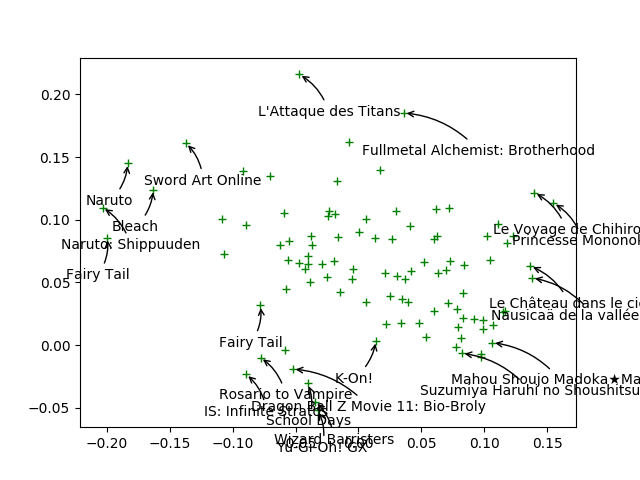

In [51]:
%matplotlib notebook
import matplotlib.pyplot as plt

class MangakiViz:
    label = None
    def __init__(self, titles, coords, drawn, featured):
        fig = plt.figure()
        self.label = {}
        for work_id in drawn:
            p_id = work_id
            x, y = coords[p_id, 0], coords[p_id, 1]
            self.label[(x, y)] = titles[work_id]
            if p_id in featured:
                plt.plot(x, y, 'sb')  # Special points
                self.display(x, y)
            else:
                plt.plot(x, y, '+g', picker=5)
        # plt.plot(jjx, jjy, 'or')
        # plt.plot(predx, predy, 'og')
        fig.canvas.mpl_connect('pick_event', self.onpick)
    
    def display(self, x, y):
        plt.annotate(self.label[(x, y)], xy=(x, y), xycoords='data',
            xytext=(-30, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=.2")
            )
    
    def where_am_i(self, point):
        plt.plot(point[0], point[1], 'or')
    
    def draw_history(self, history):
        plt.plot(history[:, 0], history[:, 1], 'og')
    
    def onpick(self, event):
        thisline = event.artist
        xdata = thisline.get_xdata()
        ydata = thisline.get_ydata()
        ind = event.ind
        points = tuple(zip(xdata[ind], ydata[ind]))
        x, y = points[0]
        self.display(x, y)

sampled_items = []
titles = dataset.titles#works[:, 1].tolist()
viz = MangakiViz(titles, svd.VT.T, popular_ids, sampled_items)
# viz.where_am_i((-0.61951029531106994, -0.15674103238147402))  # Old Ryan
# viz.where_am_i((clf.coef_[0][:2]))